## Importing




---

Import the data from kaggle using kaggle.json file and unzipping it

In [ ]:
!pip install -q kaggle

In [ ]:
from google.colab import files
uploaded = files.upload()  # Upload kaggle.json

Saving kaggle.json to kaggle.json


In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d jessicali9530/lfw-dataset

Dataset URL: https://www.kaggle.com/datasets/jessicali9530/lfw-dataset
License(s): other


In [ ]:
import zipfile
import os

zip_path = '/content/lfw-dataset.zip'
extract_path = '/content/lfw_dataset'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# List the extracted files to verify
os.listdir(extract_path)

['matchpairsDevTest.csv',
 'peopleDevTrain.csv',
 'mismatchpairsDevTest.csv',
 'mismatchpairsDevTrain.csv',
 'lfw_readme.csv',
 'lfw_allnames.csv',
 'people.csv',
 'matchpairsDevTrain.csv',
 'pairs.csv',
 'lfw-deepfunneled',
 'peopleDevTest.csv']

## Load the images and visualize it as 48*48

In [ ]:
from PIL import Image
import numpy as np

def load_image(image_path):
    """Load an image and convert to numpy array."""
    img = Image.open(image_path).convert('RGB')
    return np.array(img)

# Path to lfw-deepfunneled folder
lfw_folder = '/content/lfw_dataset/lfw-deepfunneled/lfw-deepfunneled'

# Dictionary to store images by person
image_dict = {}

# Walk through the lfw-deepfunneled directory
for root, dirs, files in os.walk(lfw_folder):
    for file in files:
        if file.endswith('.jpg'):
            person_name = os.path.basename(root)
            image_path = os.path.join(root, file)
            if person_name not in image_dict:
                image_dict[person_name] = []
            image_dict[person_name].append(image_path)

print(f"Loaded images for {len(image_dict)} individuals.")

Loaded images for 5749 individuals.


In [ ]:
import pandas as pd

# Load pair files
match_train = pd.read_csv('/content/lfw_dataset/matchpairsDevTrain.csv')
match_test = pd.read_csv('/content/lfw_dataset/matchpairsDevTest.csv')

def create_positive_pairs(df, lfw_folder):
    pairs = []
    labels = []
    for _, row in df.iterrows():
        person = row['name']
        img1_num = row['imagenum1']
        img2_num = row['imagenum2']
        # Construct image paths (e.g., George_W_Bush/George_W_Bush_0001.jpg)
        img1_path = os.path.join(lfw_folder, person, f"{person}_{img1_num:04d}.jpg")
        img2_path = os.path.join(lfw_folder, person, f"{person}_{img2_num:04d}.jpg")
        if os.path.exists(img1_path) and os.path.exists(img2_path):
            pairs.append((img1_path, img2_path))
            labels.append(1)  # Positive pair (same person)
    return pairs, labels

# Create positive pairs
positive_pairs_train, positive_labels_train = create_positive_pairs(match_train, lfw_folder)
positive_pairs_test, positive_labels_test = create_positive_pairs(match_test, lfw_folder)

print(f"Positive pairs (train): {len(positive_pairs_train)}")
print(f"Positive pairs (test): {len(positive_pairs_test)}")

Positive pairs (train): 1100
Positive pairs (test): 500


In [ ]:
# Load mismatch pair files
mismatch_train = pd.read_csv('/content/lfw_dataset/mismatchpairsDevTrain.csv')
mismatch_test = pd.read_csv('/content/lfw_dataset/mismatchpairsDevTest.csv')

def create_negative_pairs(df, lfw_folder):
    pairs = []
    labels = []
    for _, row in df.iterrows():
        person1 = row['name']
        img1_num = row['imagenum1']
        person2 = row['name.1']
        img2_num = row['imagenum2']
        img1_path = os.path.join(lfw_folder, person1, f"{person1}_{img1_num:04d}.jpg")
        img2_path = os.path.join(lfw_folder, person2, f"{person2}_{img2_num:04d}.jpg")
        if os.path.exists(img1_path) and os.path.exists(img2_path):
            pairs.append((img1_path, img2_path))
            labels.append(0)  # Negative pair (different people)
    return pairs, labels

# Create negative pairs
negative_pairs_train, negative_labels_train = create_negative_pairs(mismatch_train, lfw_folder)
negative_pairs_test, negative_labels_test = create_negative_pairs(mismatch_test, lfw_folder)

print(f"Negative pairs (train): {len(negative_pairs_train)}")
print(f"Negative pairs (test): {len(negative_pairs_test)}")

Negative pairs (train): 1100
Negative pairs (test): 500


In [ ]:
def preprocess_image(image_path, size=(48, 48)):
    img = load_image(image_path)
    img = Image.fromarray(img).resize(size)
    img = np.array(img) / 255.0  # Normalize to [0, 1]
    return img

def preprocess_pairs(pairs):
    processed_pairs = []
    for img1_path, img2_path in pairs:
        img1 = preprocess_image(img1_path)
        img2 = preprocess_image(img2_path)
        processed_pairs.append((img1, img2))
    return processed_pairs

# Preprocess all pairs
positive_pairs_train_proc = preprocess_pairs(positive_pairs_train)
positive_pairs_test_proc = preprocess_pairs(positive_pairs_test)
negative_pairs_train_proc = preprocess_pairs(negative_pairs_train)
negative_pairs_test_proc = preprocess_pairs(negative_pairs_test)

In [ ]:
# Combine train pairs and labels
train_pairs = positive_pairs_train_proc + negative_pairs_train_proc
train_labels = positive_labels_train + negative_labels_train

# Combine test pairs and labels
test_pairs = positive_pairs_test_proc + negative_pairs_test_proc
test_labels = positive_labels_test + negative_labels_test

# Convert to numpy arrays
train_pairs = np.array(train_pairs)
train_labels = np.array(train_labels)
test_pairs = np.array(test_pairs)
test_labels = np.array(test_labels)

print(f"Train set: {len(train_pairs)} pairs")
print(f"Test set: {len(test_pairs)} pairs")

Train set: 2200 pairs
Test set: 1000 pairs


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Lambda, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow.keras.backend as K
import numpy as np


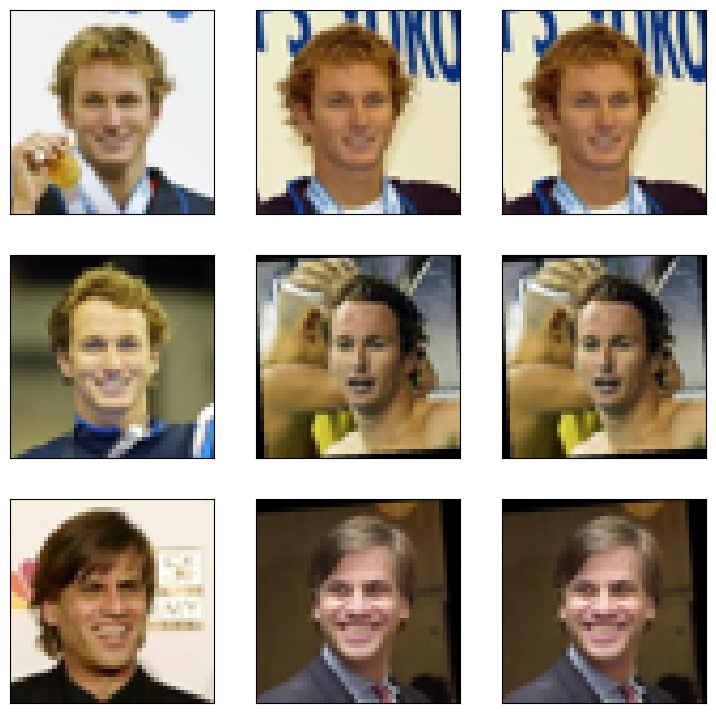

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
import numpy as np
import matplotlib.pyplot as plt

def visualize(anchor, positive, negative):
    """Visualize a few triplets from the supplied batches."""

    def show(ax, image):
        ax.imshow(image)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    fig = plt.figure(figsize=(9, 9))

    axs = fig.subplots(3, 3)
    for i in range(3):
        show(axs[i, 0], anchor[i])
        show(axs[i, 1], positive[i])
        show(axs[i, 2], negative[i])

# Convert train_pairs to a list of tuples before visualizing
train_pairs_list = [tuple(pair) for pair in train_pairs]

anchor, positive = zip(*train_pairs_list[:3])
negative = positive
visualize(np.array(anchor), np.array(positive), np.array(negative))  # Convert back to NumPy arrays

## Modeling

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model, metrics
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:

class DistanceLayer(layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive, negative):
        ap_distance = tf.reduce_sum(tf.square(anchor - positive), -1)
        an_distance = tf.reduce_sum(tf.square(anchor - negative), -1)
        return ap_distance, an_distance


###Siamese Network

In [ ]:

class SiameseModel(Model):
    def __init__(self, siamese_network, margin=0.5):
        super().__init__()
        self.siamese_network = siamese_network
        self.margin = margin
        self.loss_tracker = metrics.Mean(name="loss")

    def call(self, inputs):
        return self.siamese_network(inputs)

    def train_step(self, data):
        # Get the data
        (anchor, positive, negative), _ = data

        with tf.GradientTape() as tape:
            # Forward pass
            ap_distance, an_distance = self.siamese_network([anchor, positive, negative])

            # Compute loss
            loss = ap_distance - an_distance
            loss = tf.maximum(loss + self.margin, 0.0)
            loss = tf.reduce_mean(loss)

        # Compute gradients
        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)

        # Update weights
        self.optimizer.apply_gradients(zip(gradients, self.siamese_network.trainable_weights))

        # Update metrics
        self.loss_tracker.update_state(loss)

        # Return metrics
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        # Get the data
        (anchor, positive, negative), _ = data

        # Forward pass
        ap_distance, an_distance = self.siamese_network([anchor, positive, negative])

        # Compute loss
        loss = ap_distance - an_distance
        loss = tf.maximum(loss + self.margin, 0.0)
        loss = tf.reduce_mean(loss)

        # Update metrics
        self.loss_tracker.update_state(loss)

        # Return metrics
        return {"loss": self.loss_tracker.result()}

    @property
    def metrics(self):
        return [self.loss_tracker]


###Embedding network

---

convert the images into embedding "numerical"

In [ ]:

def build_embedding_model():
    inputs = tf.keras.Input(shape=(48, 48, 3))
    x = layers.Conv2D(64, (3, 3), activation='relu')(inputs)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(128, (3, 3), activation='relu')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))(x)  # normalize embeddings
    return tf.keras.Model(inputs, x, name="embedding")

embedding = build_embedding_model()

In [ ]:

target_shape = (48, 48)

anchor_input = layers.Input(name="anchor", shape=target_shape + (3,))
positive_input = layers.Input(name="positive", shape=target_shape + (3,))
negative_input = layers.Input(name="negative", shape=target_shape + (3,))

anchor_emb = embedding(anchor_input)
positive_emb = embedding(positive_input)
negative_emb = embedding(negative_input)

distances = DistanceLayer()(anchor_emb, positive_emb, negative_emb)

siamese_network = Model(
    inputs=[anchor_input, positive_input, negative_input],
    outputs=distances,
    name="SiameseNetwork"
)


### prepare our data from pairt to triples

---

anchor, positive, negative

In [ ]:

BATCH_SIZE = 32

def prepare_triplets(pairs, labels):


    positive_indices = np.where(labels == 1)[0]
    negative_indices = np.where(labels == 0)[0]


    anchors = []
    positives = []
    negatives = []

    for pos_idx in positive_indices:
        anchor, positive = pairs[pos_idx]

        neg_idx = np.random.choice(negative_indices)
        _, negative = pairs[neg_idx]

        anchors.append(anchor)
        positives.append(positive)
        negatives.append(negative)

    return np.array(anchors), np.array(positives), np.array(negatives)


### split the data to train, test

In [ ]:

train_anchors, train_positives, train_negatives = prepare_triplets(train_pairs, train_labels)

train_dataset = tf.data.Dataset.from_tensor_slices((
    (train_anchors, train_positives, train_negatives),
    np.zeros(len(train_anchors))  # Dummy labels
)).shuffle(buffer_size=1024).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

test_anchors, test_positives, test_negatives = prepare_triplets(test_pairs, test_labels)

test_dataset = tf.data.Dataset.from_tensor_slices((
    (test_anchors, test_positives, test_negatives),
    np.zeros(len(test_anchors))  # Dummy labels
)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


In [ ]:

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

siamese_model = SiameseModel(siamese_network)
siamese_model.compile(optimizer=Adam(0.0001))

history = siamese_model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=20,
    callbacks=[early_stopping]
)


Epoch 1/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 35s 947ms/step - loss: 0.4161 - val_loss: 0.3870
Epoch 2/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 33s 958ms/step - loss: 0.2922 - val_loss: 0.3625
Epoch 3/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 34s 970ms/step - loss: 0.2389 - val_loss: 0.3814
Epoch 4/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 28s 790ms/step - loss: 0.2283 - val_loss: 0.3263
Epoch 5/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 32s 909ms/step - loss: 0.1866 - val_loss: 0.3503
Epoch 6/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 36s 761ms/step - loss: 0.1532 - val_loss: 0.3536
Epoch 7/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 27s 784ms/step - loss: 0.1208 - val_loss: 0.3515
Epoch 8/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 48s 985ms/step - loss: 0.1067 - val_loss: 0.3519
Epoch 9/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 33s 738ms/step - loss: 0.0605 - val_loss: 0.3395


In [ ]:

# Save the models
embedding.save('siamese_embedding_model.h5')


###Adds a batch dim(which means 1 for single instanec) and make face verification

---

Calculates the Euclidean distance between the two pairs and return the matched faces

In [ ]:

def compute_embedding(image):
    image = np.expand_dims(image, axis=0)

    return embedding.predict(image)

def verify_faces(face1, face2, threshold=0.5):

    emb1 = compute_embedding(face1)
    emb2 = compute_embedding(face2)

    distance = np.sum(np.square(emb1 - emb2))

    return distance < threshold, distance

In [ ]:
from sklearn.metrics import accuracy_score
test_accuracy = compute_verification_accuracy(siamese_network, test_pairs, test_labels)
test_accuracy


np.float64(0.665)